### Imports

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path
scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

In [4]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.superpixel import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.get_statistics import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from Pipeline.pre_processing_pipeline import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import preprocessing_config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

### Loading the data

In [5]:
# temp_pipeline = PreProcessingPipelineTemporal()

In [6]:
# train_fn, dataloader_train = temp_pipeline.get_processed_trainloader(64, 'indexbands', vi_type='msi')

Train

In [7]:
temporal_images = load_field_images_temporal(config.base_directory_temporal_train1)
border_removed_images_train = blacken_field_borders_temporal(temporal_images)
field_numbers_train, indices_images_train = multiple_indices_temporal_cubes(border_removed_images_train)

len(indices_images_train), indices_images_train[0][0].shape

(2425, (64, 64, 3))

Evaluation

In [8]:
temporal_images_eval = load_field_images_temporal(config.base_directory_temporal_test1)
border_removed_images = blacken_field_borders_temporal(temporal_images_eval)
field_numbers_eval, indices_images_eval = multiple_indices_temporal_cubes(border_removed_images)

(len(indices_images_eval), indices_images_eval[0][0].shape)

(48, (64, 64, 3))

In [9]:
image_tensor_train = np.stack(indices_images_train)  # Shape: (N x 7 x 64 x 64 x 6)
image_tensor_eval = np.stack(indices_images_eval)   # Shape: (N x 7 x 64 x 64 x 6)

image_tensor_train.shape, image_tensor_eval.shape

((2425, 7, 64, 64, 3), (48, 7, 64, 64, 3))

In [10]:
image_tensor_train = torch.tensor(image_tensor_train, dtype=torch.float32).permute(0, 1, 4, 2, 3)  # (N, T, H, W, C) -> (N, T, C, H, W)
image_tensor_eval = torch.tensor(image_tensor_eval, dtype=torch.float32).permute(0, 1, 4, 2, 3)  # (N, T, H, W, C) -> (N, T, C, H, W)
image_tensor_train.shape, image_tensor_eval.shape

(torch.Size([2425, 7, 3, 64, 64]), torch.Size([48, 7, 3, 64, 64]))

### Temporary Cells for getting pictures for our thesis

In [11]:
indices_images_train[0][0].shape

(64, 64, 3)

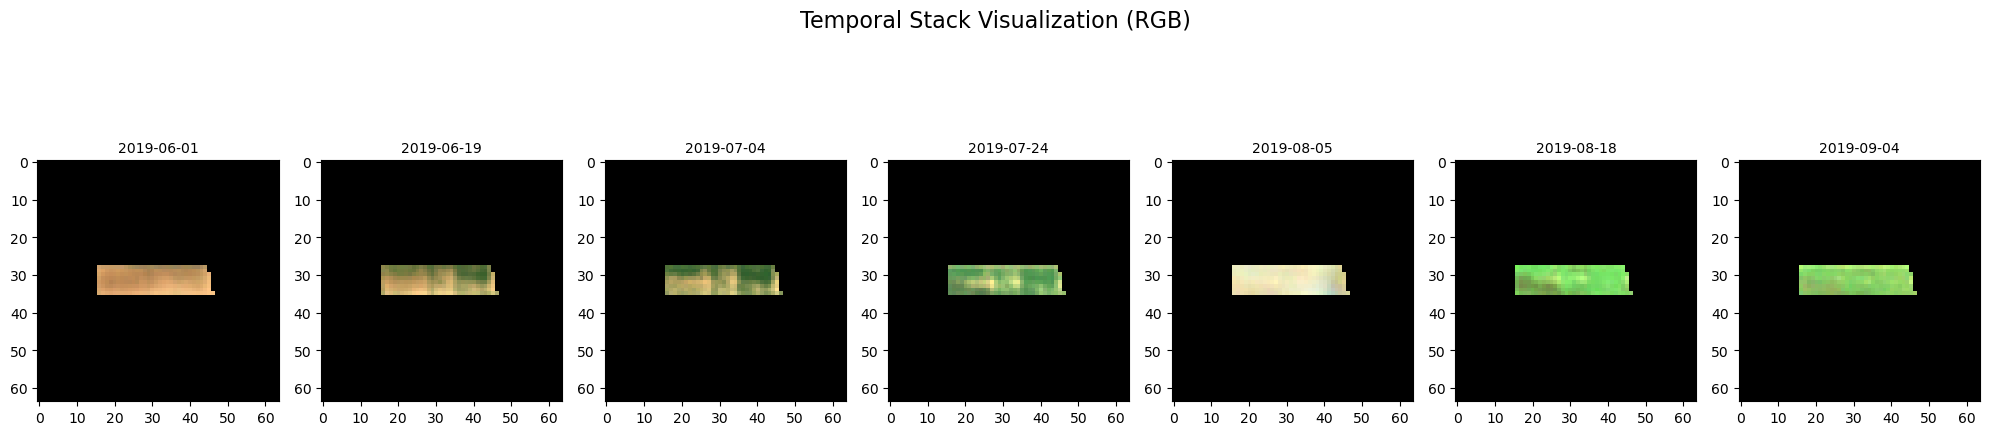

In [12]:
visualize_temporal_stack_rgb(temporal_images_eval[47])

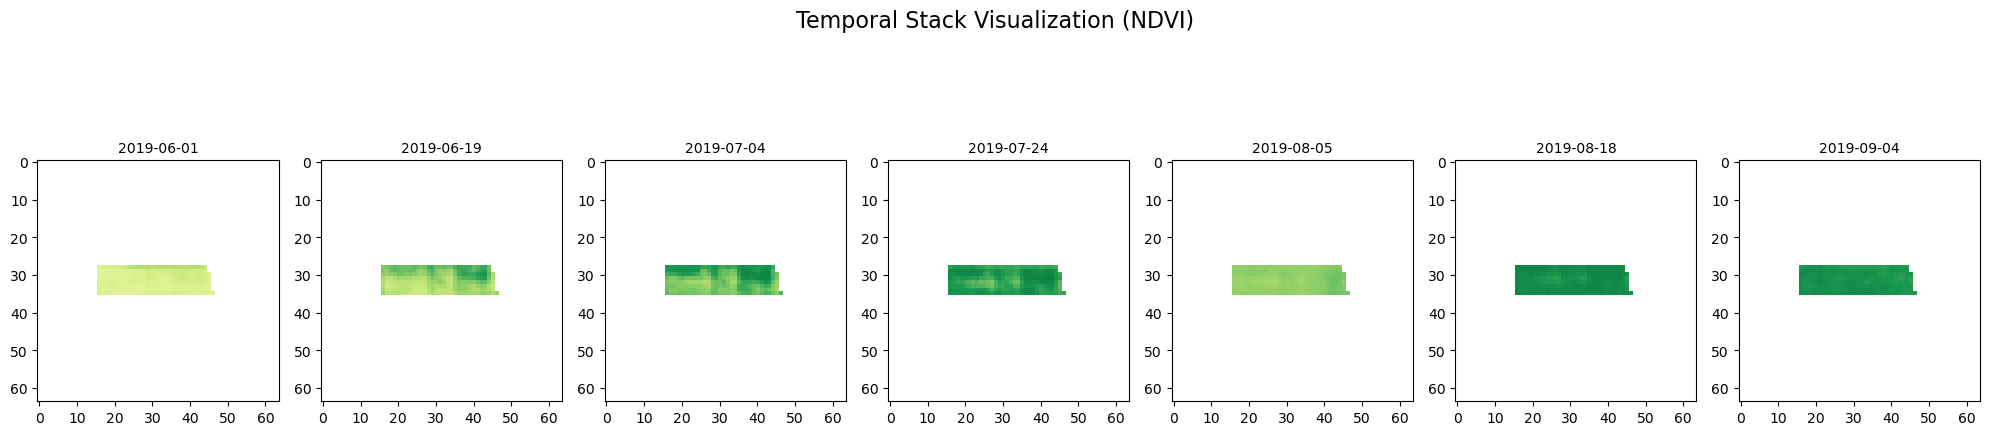

In [24]:
visualize_temporal_stack_ndvi(temporal_images_eval[47])

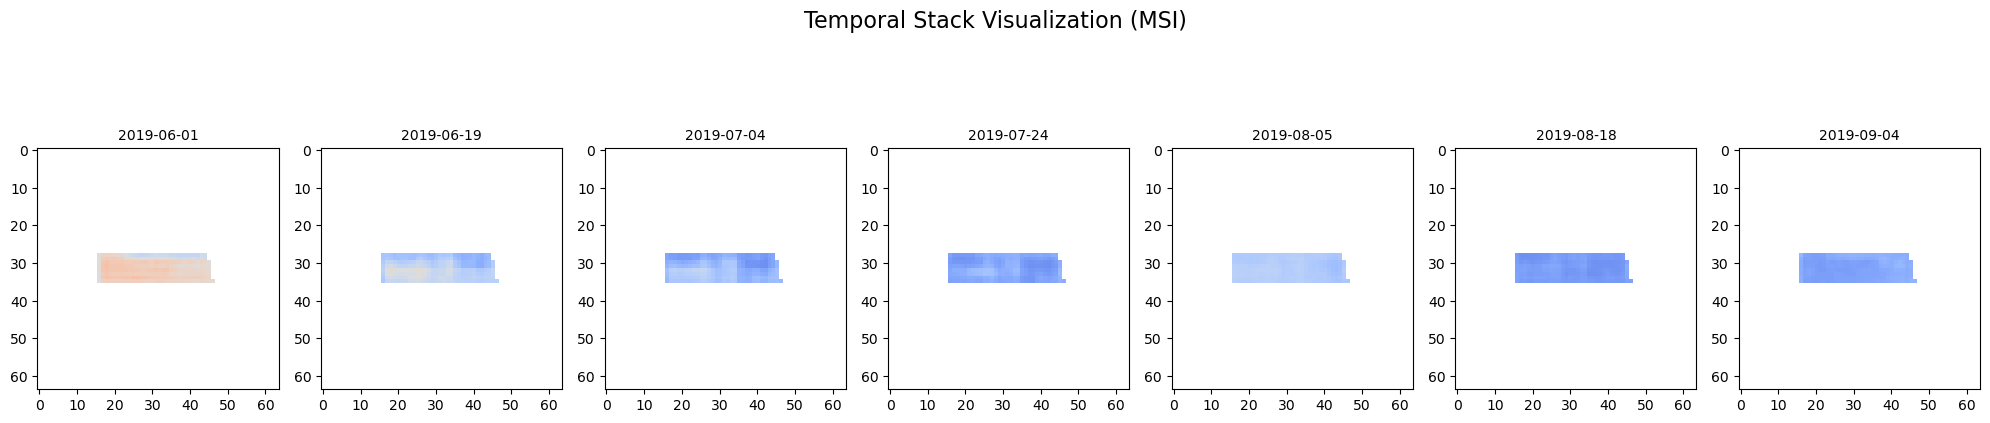

In [25]:
visualize_temporal_stack_msi(temporal_images_eval[47])

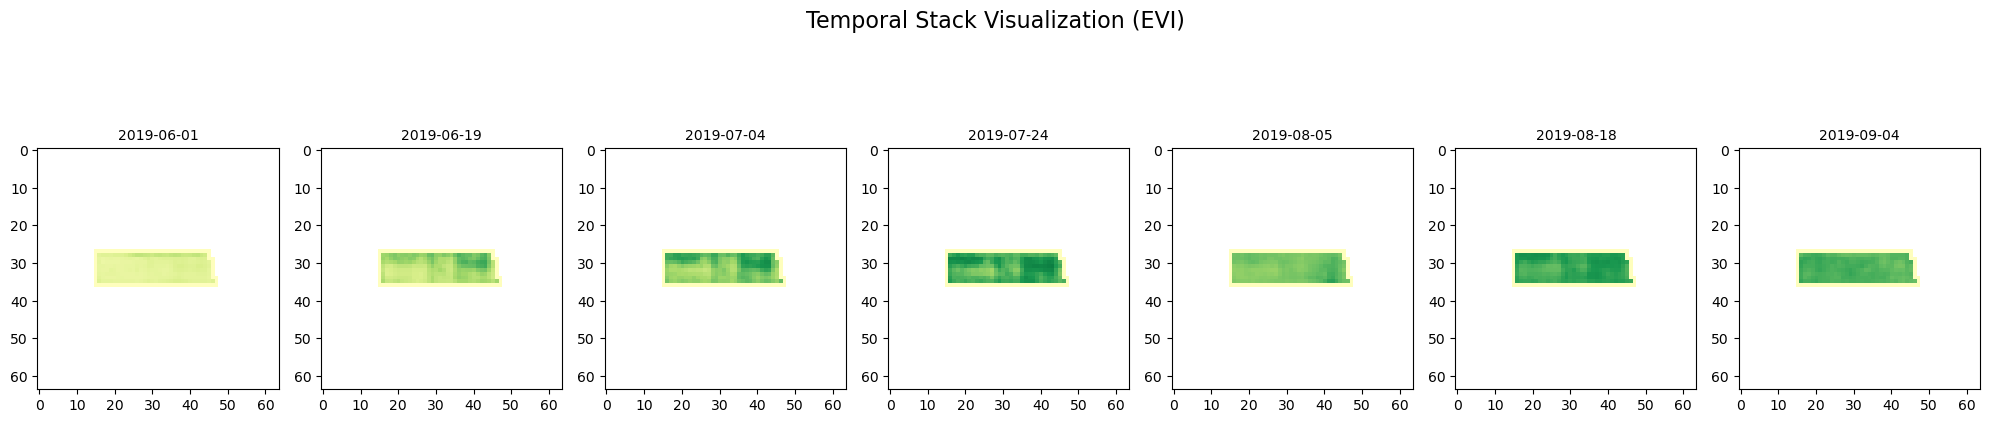

In [26]:
visualize_temporal_stack_evi(temporal_images_eval[47])

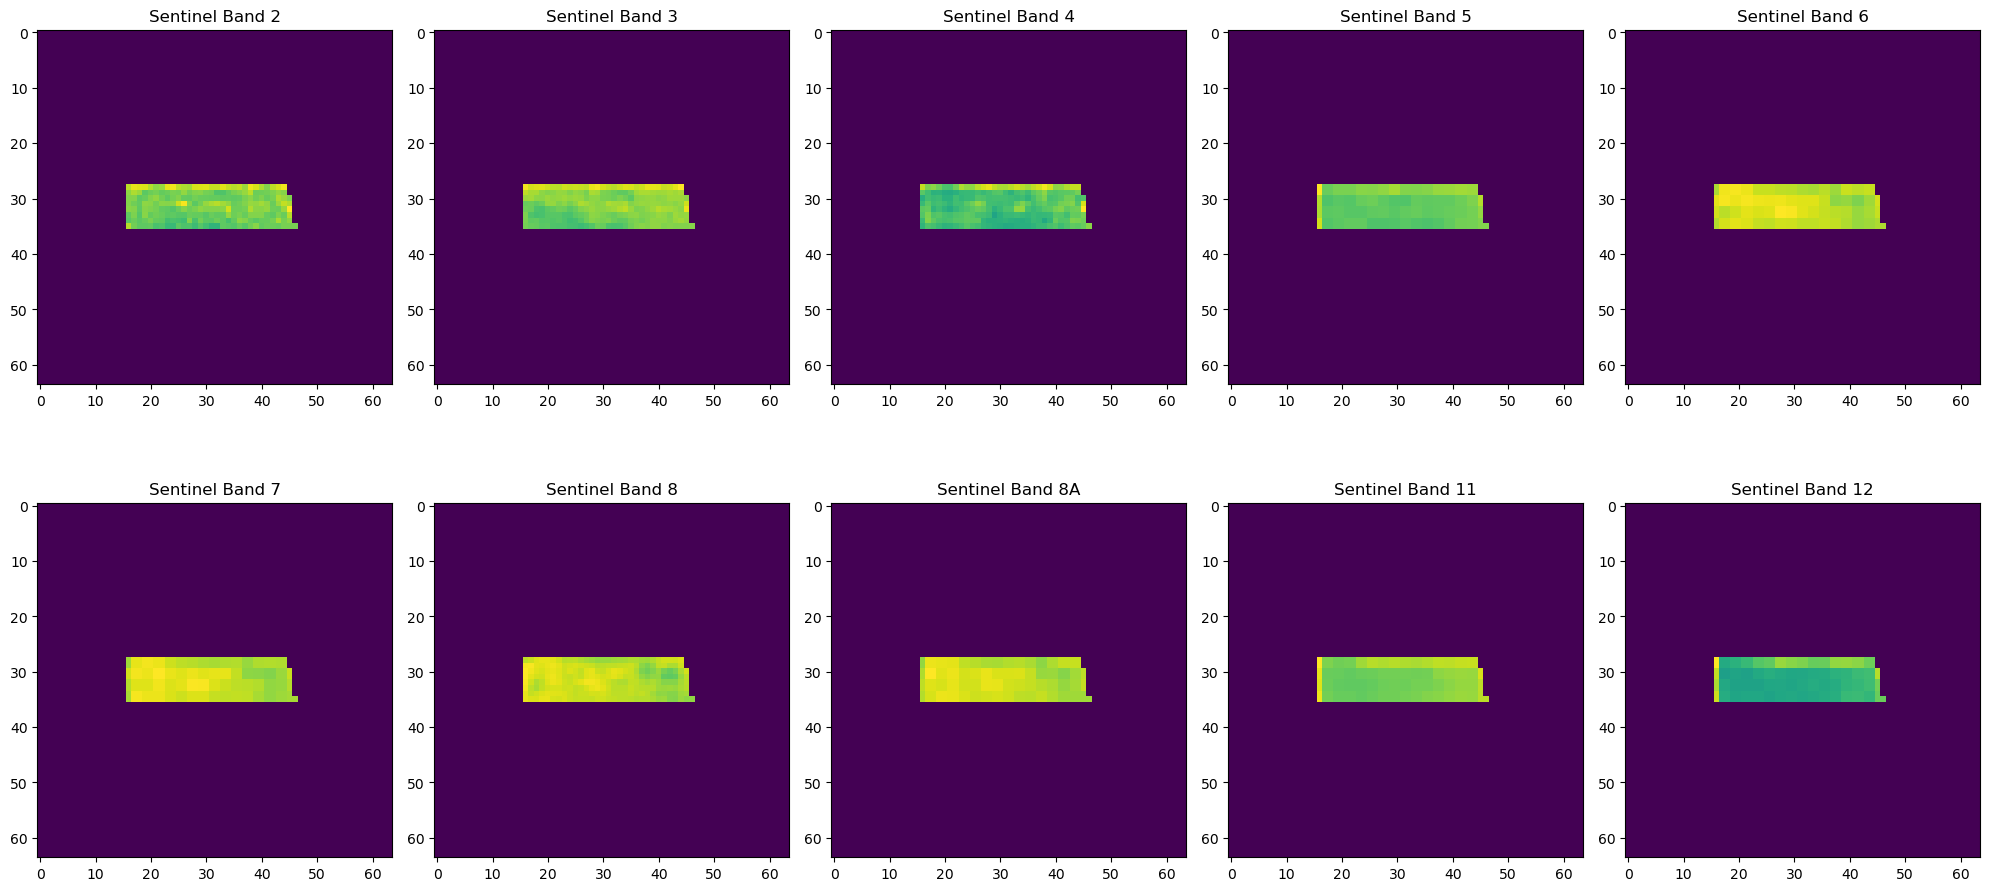

In [58]:
visualise_all_bands_wo_masks(temporal_images_eval[47][-1])

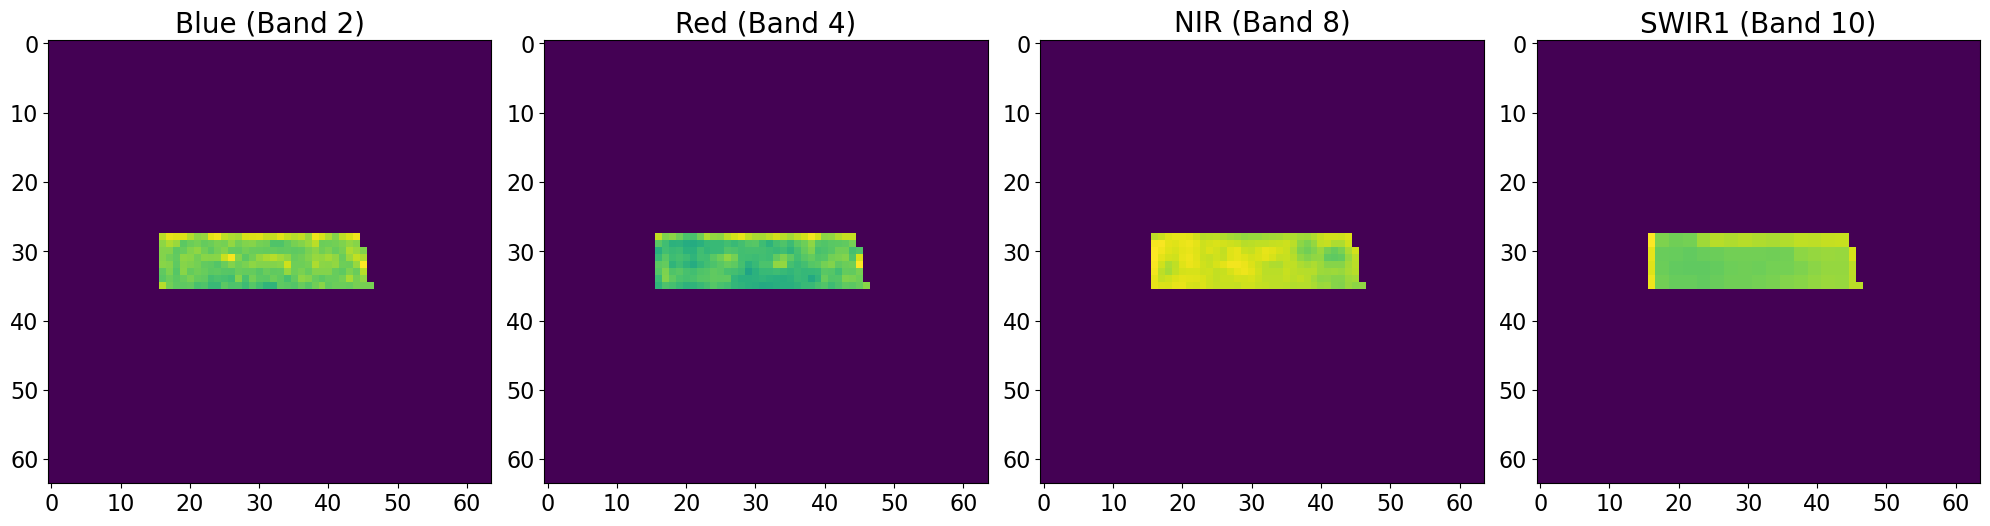

In [34]:
visualise_selected_bands(temporal_images_eval[47][-1])

In [61]:
np.unique(temporal_images_eval[47][-1][:,:,-2])

array([      0., 1230818.])

### Mini-patches

In [13]:
train_patches, train_patch_coordinates = non_overlapping_sliding_window(image_tensor_train, field_numbers_train, patch_size=5)
eval_patches, eval_patch_coordinates = non_overlapping_sliding_window(image_tensor_eval, field_numbers_eval, patch_size=5)
len(eval_patches), eval_patches[0].shape

(867, torch.Size([7, 3, 5, 5]))

In [19]:
len(train_patches), len(train_patch_coordinates)

(39042, 39042)

In [20]:
train_patches = np.stack(train_patches)  # Shape: (N x 7 x 6 x 5 x 5)
eval_patches = np.stack(eval_patches)   # Shape: (N x 7 x 6 x 5 x 5)

In [21]:
train_patch_coordinates[0]

('1167134.0', 25, 25)

In [22]:
train_coord_dataloader = field_nos_dataloader(train_patch_coordinates)
eval_coord_dataloader = field_nos_dataloader(eval_patch_coordinates)
train_coord_dataloader[0]

'1167134.0_25_25'

In [23]:
len(train_coord_dataloader)

39042

### Data Loaders

In [24]:
# batch_size = 64
# dataloader_train = create_data_loader(train_patches, train_coord_dataloader, batch_size=batch_size, shuffle=True)

# for batch_inputs, batch_field_numbers in dataloader_train:
#     print("Batch Inputs Shape:", batch_inputs.shape) 
#     print("Batch Field Numbers:", batch_field_numbers)
#     break  

In [25]:
train_patches.shape

(39042, 7, 3, 5, 5)

In [26]:
len(train_coord_dataloader)

39042

In [27]:
len(train_patch_coordinates)

39042

In [28]:
train_ratio = 0.8  

# Split patches and corresponding field numbers
train_patches, test_patches, train_field_numbers, test_field_numbers = train_test_split(
    train_patches, train_coord_dataloader, test_size=1-train_ratio, random_state=42
)

# Create train and test dataloaders
batch_size = 64
dataloader_train = create_data_loader(train_patches, train_field_numbers, batch_size=batch_size, shuffle=True)
dataloader_test = create_data_loader(test_patches, test_field_numbers, batch_size=batch_size, shuffle=False)

for batch_inputs, batch_field_numbers in dataloader_train:
    print("Train Batch Inputs Shape:", batch_inputs.shape)
    print("Train Batch Field Numbers:", batch_field_numbers)
    break  

for batch_inputs, batch_field_numbers in dataloader_test:
    print("Test Batch Inputs Shape:", batch_inputs.shape)
    print("Test Batch Field Numbers:", batch_field_numbers)
    break  

Train Batch Inputs Shape: torch.Size([64, 3, 7, 5, 5])
Train Batch Field Numbers: ('1195948.0_25_25', '1172749.0_1224164.0_20_15', '1182510.0_1184067.0_1221138.0_1221139.0_35_30', '1179773.0_40_30', '1229755.0_20_30', '1181097.0_1182715.0_1194877.0_1215692.0_1218299.0_1227419.0_15_5', '1177575.0_1177582.0_20_5', '1185905.0_35_30', '1172753.0_1172754.0_1172756.0_1227428.0_15_30', '1180888.0_1180895.0_35_25', '1215685.0_1227326.0_35_15', '1175475.0_20_30', '1218401.0_1230937.0_35_35', '1222518.0_30_30', '1194474.0_20_25', '1183041.0_1183046.0_35_35', '1195949.0_1195950.0_1220447.0_15_25', '1219689.0_1223637.0_1223693.0_1224346.0_20_35', '1177276.0_1177288.0_25_5', '1185902.0_1215721.0_1223285.0_1223290.0_1224130.0_1224133.0_1224134.0_20_0', '1194820.0_30_40', '1180031.0_1195716.0_35_20', '1223989.0_30_25', '1170182.0_1220443.0_35_35', '1187299.0_30_25', '1223877.0_35_30', '1216329.0_1216330.0_1216853.0_1216856.0_1220987.0_1220988.0_1228005.0_30_35', '1223399.0_1226012.0_25_20', '1196255.

In [29]:
batch_size = 64
dataloader_eval = create_data_loader(eval_patches, eval_coord_dataloader, batch_size=batch_size, shuffle=False)

for batch_inputs, batch_field_numbers in dataloader_eval:
    print("Eval Batch Inputs Shape:", batch_inputs.shape) 
    print("Eval Batch Field Numbers:", batch_field_numbers)
    break  

Eval Batch Inputs Shape: torch.Size([64, 3, 7, 5, 5])
Eval Batch Field Numbers: ('1168039.0_20_25', '1168039.0_20_30', '1168039.0_20_35', '1168039.0_25_25', '1168039.0_25_30', '1168039.0_25_35', '1168039.0_30_25', '1168039.0_30_30', '1168039.0_30_35', '1168039.0_35_25', '1168039.0_35_30', '1168039.0_35_35', '1228889.0_25_15', '1228889.0_25_20', '1228889.0_25_25', '1228889.0_25_30', '1228889.0_25_35', '1228889.0_25_40', '1228889.0_30_15', '1228889.0_30_20', '1228889.0_30_25', '1228889.0_30_30', '1228889.0_30_35', '1228889.0_30_40', '1228889.0_35_15', '1228889.0_35_20', '1228889.0_35_25', '1228889.0_35_30', '1168663.0_1176271.0_25_35', '1168663.0_1176271.0_25_40', '1168663.0_1176271.0_30_20', '1168663.0_1176271.0_30_25', '1168663.0_1176271.0_30_30', '1168663.0_1176271.0_30_35', '1168663.0_1176271.0_30_40', '1168663.0_1176271.0_35_20', '1168663.0_1176271.0_35_25', '1168663.0_1176271.0_35_30', '1168663.0_1176271.0_35_35', '1168663.0_1176271.0_35_40', '1168692.0_1220431.0_15_20', '1168692.0

### Modeling - Autoencoder

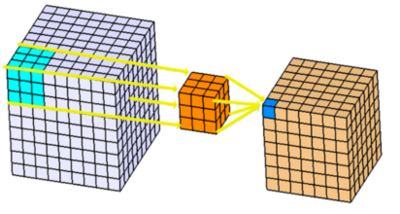

Input Data: ( N x C x D x H x W )

In [ ]:
# class Conv3DAutoencoder(nn.Module):
#     def __init__(self, in_channels, time_steps, latent_size):
#         super(Conv3DAutoencoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Conv3d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(in_features=128 * time_steps * 4 * 4, out_features=latent_size)  
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=latent_size, out_features=128 * time_steps * 4 * 4),
#             nn.ReLU(),
#             nn.Unflatten(1, (128, time_steps, 4, 4)),  
#             nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),  
#             nn.ReLU(),
#             nn.ConvTranspose3d(in_channels=64, out_channels=in_channels, kernel_size=3, stride=1, padding=1), 
#             nn.Sigmoid()  
#         )

#     def forward(self, x):
#         z = self.encoder(x)  
#         x_reconstructed = self.decoder(z) 
#         return z, x_reconstructed

In [32]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)  # Output: [64, time_steps, 5, 5]
        # self.bn1 = nn.BatchNorm3d(64)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)  # Output: [128, time_steps, 5, 5]
        # self.bn2 = nn.BatchNorm3d(128)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)  # Output: [256, time_steps, 5, 5]
        # self.bn3 = nn.BatchNorm3d(256)

        # --- Linear layers ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * time_steps * 5 * 5, 1024)  
        self.fc2 = nn.Linear(1024, latent_size)

        # --- Decoder ---
        self.fc3 = nn.Linear(latent_size, 1024)
        self.fc4 = nn.Linear(1024, 256 * time_steps * 5 * 5)  
        self.unflatten = nn.Unflatten(1, (256, time_steps, 5, 5))  

        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        # self.bn4 = nn.BatchNorm3d(128)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        # self.bn5 = nn.BatchNorm3d(64)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu((self.conv1(x)))  # Output size: [64, time_steps, 5, 5]
        x = F.relu((self.conv2(x)))  # Output size: [128, time_steps, 5, 5]
        x = F.relu((self.conv3(x)))  # Output size: [256, time_steps, 5, 5]

        # Flatten and pass to Linear layers
        x_flat = self.flatten(x)
        # print(f"Flattened size before Linear: {x_flat.size()}")  # (batch_size, 256 * time_steps * 5 * 5)
        
        x = F.relu(self.fc1(x_flat))
        z = self.fc2(x)

        # Decoder
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))
        x = self.unflatten(x)

        x = F.relu((self.deconv1(x)))
        x = F.relu((self.deconv2(x)))
        x_reconstructed = self.deconv3(x)

        return z, x_reconstructed


### Training

In [33]:
# Train
device = 'cpu'
epochs = 3
lr = 0.001
latent_dim=100
channels = 6
time_steps = 7

model = Conv3DAutoencoder(channels, time_steps, latent_dim)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(6, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=44800, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=44800, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 5, 5))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

In [ ]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

### Evaluation

In [ ]:
# Extract features and field numbers
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

In [ ]:
kmeans = train_kmeans_patches(train_features, n_clusters=2, random_state=406)
# kmeans = KMeans(n_clusters=2, random_state=2)
# kmeans.fit(train_features)

train_patch_predictions = kmeans.predict(train_features.reshape(train_features.size(0), -1).numpy().astype(np.float32))
test_patch_predictions = kmeans.predict(test_features.reshape(test_features.size(0), -1).numpy().astype(np.float32))
eval_patch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

resume

In [ ]:
# Assign field labels
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(train_coord_dl, train_patch_predictions, threshold)
test_field_labels = assign_field_labels_ae(test_coord_dl, test_patch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_patch_predictions, threshold)

In [ ]:
accuracy, report, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Test Accuracy: {accuracy}")
print(report)

In [ ]:
# draw_diseased_patches(dataloader_test, x_y_coords)

### Modeling - kmeans

In [ ]:
image_tensor_train.shape

In [ ]:
data_flattened_train = image_tensor_train.reshape(image_tensor_train.size(0), -1).numpy()
data_flattened_train.shape

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=46)
kmeans.fit(data_flattened_train)

In [ ]:
flattened_data_test = image_tensor_eval.reshape(image_tensor_eval.size(0), -1).numpy()

In [ ]:
test_cluster_labels = kmeans.predict(flattened_data_test)

In [ ]:
accuracy, pred_aligned, gt_aligned = get_accuracy(field_numbers_eval, test_cluster_labels, config.labels_path)
accuracy

In [ ]:
pred_aligned[0], gt_aligned[0]

### Feature Extraction